Librerias

In [4]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn.tree import plot_tree

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargando el datasets

In [6]:
# Ruta del archivo Txt
df = pd.read_csv("train_new.txt", delimiter = '|') 
  
# Guardamos el dataframe en un archivo Csv
df.to_csv('hola.csv',  index = None) 

# Imprimimos los datos para comprobar
print(df.head())

  idioma                                              texto
0     en  host with After to rugby test World system, th...
1     en  and Africa in permission winners,[25] of in ye...
2     en  President tournament wearing presenting were m...
3     en  The the are 'The thirty-eight reference as Ell...
4     en  a The Rugby In and Warrant head 'The Webb and ...


Mostrar bonito

In [8]:
df[['idioma','texto']].head()

,idioma,texto
0,en,"host with After to rugby test World system, th..."
1,en,"and Africa in permission winners,[25] of in ye..."
2,en,President tournament wearing presenting were m...
3,en,The the are 'The thirty-eight reference as Ell...
4,en,a The Rugby In and Warrant head 'The Webb and ...


Se cuentan el numero total de filas en el archivo

In [10]:
# Contar el total de filas
total_filas = df.shape[0]

print("Total de filas:", total_filas)

Total de filas: 1069


Graficamos la distribucion de los datos que tenemos en las 2 categorias (en y nl)

Podemos ver que los datos estan casi perfectamente balanceados

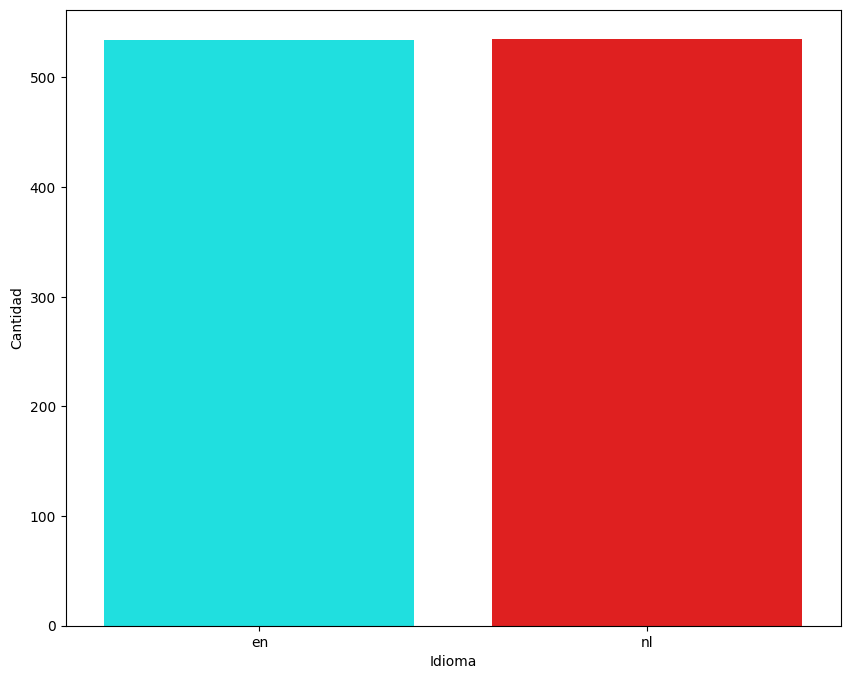

        texto  texto_tokenizado
idioma                         
en        534               534
nl        535               535


In [48]:
# Establecer el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear un countplot con las categorías "en" y "nl" de diferentes colores
sns.countplot(data=df, x='idioma', palette={'en': 'cyan', 'nl': 'red'})

# Configurar los ejes y etiquetas
plt.xlabel('Idioma')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

n_palabras = df.explode(column='idioma').groupby('idioma').count()
print(n_palabras)

In [21]:
def limpiar_tokenizar(texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()
    
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]

    
    return nuevo_texto

Asignamos estos valores a una nueva columna llamada "texto_tokenizado" y actualizamos el df

In [22]:
df['texto_tokenizado'] = df['texto'].apply(lambda x: limpiar_tokenizar(x))
df[['idioma','texto','texto_tokenizado']].to_csv('hola.csv', index=False)

Esto convierte nuestro df en uno nuevo llamado "texto_tidy" donde cada token se coloca en una fila y la columna se llama "token"

In [23]:
texto_tidy =df.explode(column='texto_tokenizado')
texto_tidy= texto_tidy.drop(columns='texto')
texto_tidy= texto_tidy.rename(columns={'texto_tokenizado':'token'})
texto_tidy.to_csv('texto_tidy.csv', index=False)

# Imprimimos los datos para comprobar
print(texto_tidy.head(10))

# Imprimimos la cantidad de filas del nuevo df "texto_tidy"
print("\nTotal de filas:", texto_tidy.shape[0])

  idioma      token
0     en       host
0     en       with
0     en      after
0     en         to
0     en      rugby
0     en       test
0     en      world
0     en     system
0     en        the
0     en  australia

Total de filas: 15909


Graficamos una nube de palabras donde se ven las palabras mas consonantes

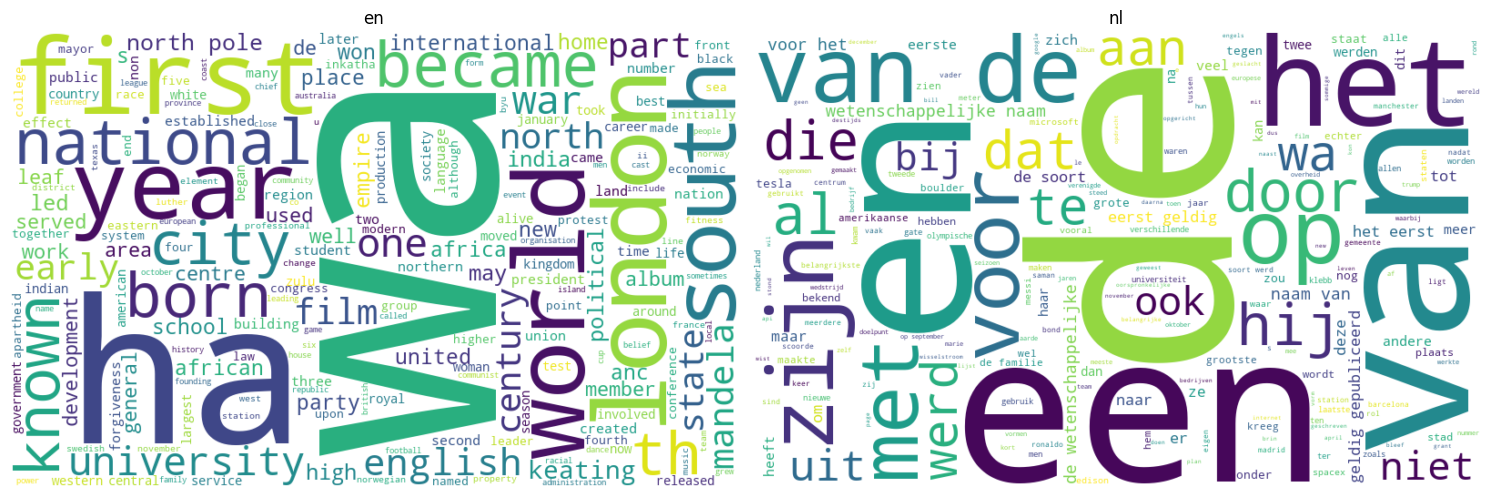

In [35]:
# Convert float items to strings in the palabras list
palabras_por_categoria = texto_tidy.groupby('idioma')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordclouds = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(' '.join(palabras))
    wordclouds[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(15, 10))
for i, (categoria, wordcloud) in enumerate(wordclouds.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

Graficamos la cantidad de palabras y su distribución 

Como podemos ver siguen una distribucion parecida a la anterior y tambien estan casi perfectamente balanceados

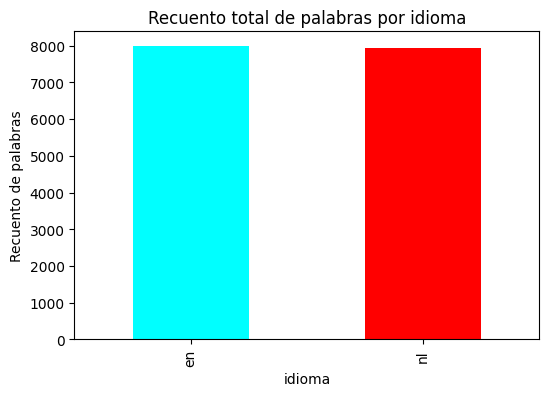


Palabras totales por idioma 

idioma
en    7986
nl    7923
Name: token, dtype: int64


In [52]:
# Recuento total de palabras por categoría
word_count = texto_tidy.groupby('idioma')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['cyan', 'red']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('idioma')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por idioma')

# Mostrar la tabla gráfica
plt.show()


print('\nPalabras totales por idioma \n')

texto_tidy.groupby(by='idioma')['token'].count()
print(word_count)

La cantidad de palabras distintas en cada idioma

In [45]:
# Palabras distintas utilizadas 
print('----------------------------')
print('Palabras distintas por idioma')
print('----------------------------')
print(texto_tidy.groupby(by='idioma')['token'].nunique())

----------------------------
Palabras distintas por idioma
----------------------------
idioma
en    2712
nl    2755
Name: token, dtype: int64


Representamos esto es un grafico circular

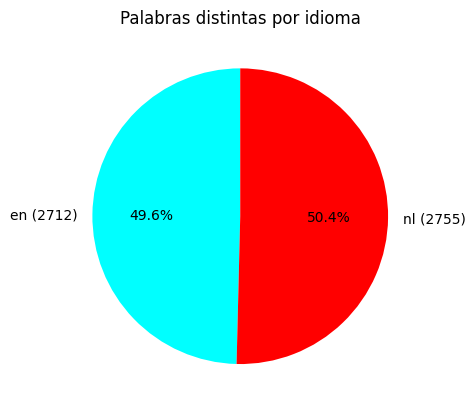

In [53]:
# Gráfico porcentaje de palabras distintas por idioma
unique_words = texto_tidy.groupby('idioma')['token'].nunique()

# Definir los colores de las categorías
colors = ['cyan', 'red']

# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por idioma')

# Mostrar el gráfico de pastel
plt.show()


Número de palabras comunes entre los idiomas

In [51]:
palabras_en = set(texto_tidy[texto_tidy.idioma == 'en']['token'])
palabras_nl = set(texto_tidy[texto_tidy.idioma == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Nerlandes: {len(palabras_en.intersection(palabras_nl))}")

Palabras comunes entre Ingles y Nerlandes: 178


Creamos un nuevo df con las palabras comunes y lo llamaremos palabras_comunes

In [55]:
palabras_comunes = palabras_en.intersection(palabras_nl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

Graficamos una nube de palabras con las palabras comunes entre los 2 idiomas

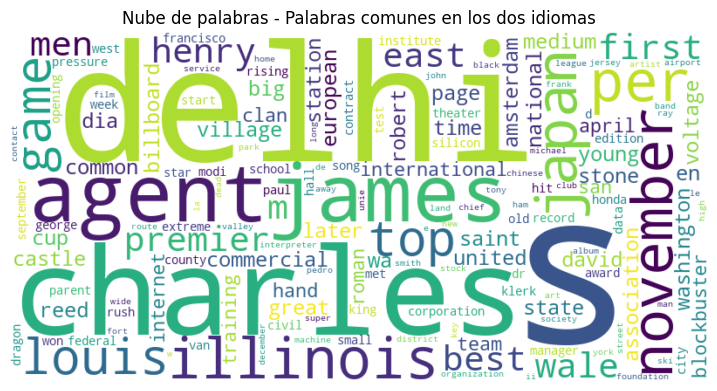

In [56]:
# Nube las palabras comunes en las dos idiomas
# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes en los dos idiomas')
plt.show()